## Analysis of top five league data using StatsBomb public data

- [Introduction](#introduction)
- [Packages Used](#Packages-Used)
- [Sourcing-Data](#Sourcing-Data)
- [EDA](#EDA)
- [Clustering](#Clustering)

### Introduction

This report examines the relationship that on-pitch performance indicators have on a team's performance, recognizing that data adoption within elite football is still relatively nascent, and the ability for decision-makers within the club to action produced insights is low. By examining these indicators, we can begin to understand what teams do well and support decision-makers in making informed decisions.

A clear output of this analysis details that a possession-based style of play is important to achieving results, and teams are recommended to reflect on the decisions made both in and out of possession to maximize their threat while disrupting their opposition.

**Research question:** How can statistical analysis be used to identify the differences between high-performing and low-performing top-tier football teams, and how could teams use these insights to enhance their on-field performance?

Whilst StatsPerform (n.d.) highlights the significant evolution of football data availability in the previous 25 years, Van Haaren notes that one of the key challenges facing data analysts in football currently is an inability to ‘translate the data into answers to the questions that practitioners have’ (SciSports, 2021).

This project was designed to deliberately tackle a key question all football clubs are likely to be reflective of: What distinguishes my team's play-style from others, and is that indicative of on-field performance? Thunberg Kalt (2024) concludes that there are ‘two more or less distinct clusters’ present within their analysis of domestic football data, but the analytical outputs are challenging to consume and are likely to fall into the challenge Van Haaren is critical of. The approach detailed in this report will take influence from Thunberg Kalt and other sports analytics reports, whilst attempting to produce an output and accompanying narrative that can be understood by practitioners.


### Packages Used

In [22]:
from statsbombpy import sb #access to StatsBomb data
import warnings #OPTIONAL: removes warnings that StatsBomb data is using an account without credentials

import pandas as pd #general data manipulation
import numpy as np #declaring matrix of zeros, alongside other numerical manipulations


from sklearn.model_selection import train_test_split #used for model evaluation
from sklearn.ensemble import RandomForestRegressor #used to enable SHAP
from sklearn.metrics import mean_squared_error, r2_score #random forest regression evaluation 
import shap #support in identifying appropriate features for selection
from statsmodels.stats.outliers_influence import variance_inflation_factor #assessing the presence of multi-collinearity

from sklearn.cluster import KMeans #clustering algorithm of choice
from sklearn.metrics import silhouette_score #assessing optimal number of clusters
from sklearn.metrics import calinski_harabasz_score #assessing optimal number of clusters

from sklearn.preprocessing import StandardScaler

import seaborn as sns #data visualisation
import matplotlib.pyplot as plt #data visualisation

### Sourcing Data

#### StatsBomb

In [2]:
warnings.filterwarnings("ignore", message="credentials were not supplied. open data access only")

In [3]:
comps = pd.DataFrame(sb.competitions())

#for loop to establish how many matches are on record for each season/competition
num_matches = []

for index, row in comps.iterrows():
    season_id = row['season_id']
    competition_id = row['competition_id']
    matches = sb.matches(competition_id=competition_id, season_id=season_id)
    num_matches.append(len(matches))

#exporting the competition/season with numMatches added to help identify leagues with high numbers

comps['numMatches'] = num_matches
comps[['competition_id', 'season_id', 'country_name', 'competition_name', 'season_name', 'numMatches']].sort_values('numMatches', ascending=False)

,competition_id,season_id,country_name,competition_name,season_name,numMatches
66,12,27,Italy,Serie A,2015/2016,380
64,2,27,England,Premier League,2015/2016,380
43,11,27,Spain,La Liga,2015/2016,380
60,7,27,France,Ligue 1,2015/2016,377
1,9,27,Germany,1. Bundesliga,2015/2016,306
...,...,...,...,...,...,...
9,16,24,Europe,Champions League,2012/2013,1
8,16,25,Europe,Champions League,2013/2014,1
31,43,55,International,FIFA World Cup,1990,1
35,43,270,International,FIFA World Cup,1962,1


Season 27 has all matches for the top five leagues in Europe so has been selected as the most appropriate collection of domestic league matches available to us for analysis.

In [4]:
s27 = comps[comps['season_id']==27] #returning just season_id 27 values
s27 = s27[s27['competition_name']!='Champions League']#omitting the Champions League given it is not a domestic competition
s27

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available,numMatches
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381,306
43,11,27,Spain,La Liga,male,False,False,2015/2016,2024-05-16T14:06:52.149840,2021-06-13T16:17:31.694,None,2024-05-16T14:06:52.149840,380
60,7,27,France,Ligue 1,male,False,False,2015/2016,2024-01-07T06:23:44.277971,None,None,2024-01-07T06:23:44.277971,377
64,2,27,England,Premier League,male,False,False,2015/2016,2024-06-12T07:43:56.243851,2021-06-13T16:17:31.694,None,2024-06-12T07:43:56.243851,380
66,12,27,Italy,Serie A,male,False,False,2015/2016,2024-06-25T23:56:11.910924,None,None,2024-06-25T23:56:11.910924,380


We will now access event level information for each match contained within the leagues, returning a dataframe that counts the occurence of each time the definition of an indicator has been met within the match. 

The list of indicators captured at this stage are:

- match_count: the number of matches each team has participated in. This is largely a validation exercise that we have captured the expected number of matches
- shots: the number of shots recorded.
- shotsOnTarget: the number of shots which were either converted or would have been converted without interruption from the goalkeeper or a defender.
- xG: the total value of expectedGoals accumulated by the team.
- goals: the number of goals scored
- own_goals: the number of own goals scored
- passes: the number of successful passes recorded
- players: the number of unique players used

This script will take a long time to complete, as we are evaluating metrics for over 1800 football matches and each match contains a few thousand entries at a time.

In [5]:
league = []
findings = []

for index, row in s27.iterrows():
    varCompetitionID = row['competition_id']
    varSeasonID = row['season_id']
    varLeagueName = row['competition_name']
    dataframe = sb.matches(competition_id=varCompetitionID, season_id=varSeasonID)
    for index, row in dataframe.iterrows():
        match_id=row['match_id']
        match_events = sb.events(match_id=match_id)
        # select columns required to extract metrics
        match = match_events[['player_id', 'type', 'team_id', 'shot_outcome', 'shot_statsbomb_xg', 'pass_height', 'match_id', 'team']]
        # remove non-player based events, half time/full-time whistle
        match = match.dropna(subset=['player_id'])
        teams=match.groupby('team')
        for team_name, team in teams:
            match_count = team['match_id'].nunique()
            shots = len(team['shot_outcome'].dropna())
            shotsOnTarget = len(team[(team['shot_outcome'] == "Goal") | (team['shot_outcome'] == "Saved")])
            xG = team['shot_statsbomb_xg'].sum()
            goals = len(team[team['shot_outcome'] == "Goal"])
            own_goals = len(team[team['type'] == 'Own Goal For'])
            match_id_val = team.drop_duplicates('match_id')['match_id'].values[0]
            passes = len(team['pass_height'].dropna())
            unique_players = team['player_id'].nunique()
            team_details = team['team_id'].astype(str) + ":"+ team['team'] 
            
            
            findings.append({
            #'team_id': team_id,
            #'team': team_name,
            'team': team_name,
            'match_id': match_id_val,
            'match_count': match_count,
            'shots': shots,
            'shotsOnTarget': shotsOnTarget,
            'xG': xG,
            'goals': goals,
            'own_goals': own_goals,
            'passes':passes,
            'players':unique_players
        })

In [6]:
data = pd.DataFrame(findings)
data

,team,match_id,match_count,shots,shotsOnTarget,xG,goals,own_goals,passes,players
0,Hoffenheim,3890561,1,13,4,1.168875,1,0,506,14
1,Schalke 04,3890561,1,12,8,1.605704,3,0,590,13
2,Bayern Munich,3890505,1,20,9,1.837664,1,0,698,13
3,Eintracht Frankfurt,3890505,1,4,0,0.121696,0,0,316,14
4,Hannover 96,3890511,1,12,3,0.800510,2,0,342,14
...,...,...,...,...,...,...,...,...,...,...
3641,Fiorentina,3878542,1,14,7,1.953590,2,0,560,14
3642,AS Roma,3878541,1,21,6,1.114252,1,0,591,14
3643,Hellas Verona,3878541,1,12,6,1.005291,1,0,300,14
3644,Bologna,3878540,1,9,4,0.615307,1,0,455,14


These are then grouped by the team name, to produce an aggregated table across the season, mitigating the risk of single match variability influencing outputs.

In [7]:
grouped_df = data.groupby(['team']).sum()
grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.drop(columns=['match_id'])
grouped_df

,team,match_count,shots,shotsOnTarget,xG,goals,own_goals,passes,players
0,AC Milan,38,565,177,53.695706,49,0,18933,522
1,AFC Bournemouth,38,478,143,40.351590,43,0,19406,526
2,AS Monaco,38,428,172,53.914821,54,0,17861,528
3,AS Roma,38,592,209,61.949056,83,0,21927,528
4,Angers,38,409,131,35.692111,40,0,16281,528
...,...,...,...,...,...,...,...,...,...
93,Watford,38,450,139,44.082146,36,0,16362,517
94,Werder Bremen,34,451,140,49.968887,49,0,13562,469
95,West Bromwich Albion,38,396,102,38.626782,32,0,13971,517
96,West Ham United,38,559,178,54.526547,64,0,16773,527


We produce a new set of  indicators, which assess the outcome of the above indicators per match, to reflect the rationale taken by Akhanli and Hennig, 2022.

In [8]:
statPerMatch = []

for index, row in grouped_df.iterrows():
    shotsPerGame = row['shots'] / row['match_count']
    SOTPerGame = row['shotsOnTarget'] / row['match_count']    
    xGPerGame = row['xG'] / row['match_count']
    goalsPerGame = row['goals'] / row['match_count']
    passesPerGame = row['passes'] / row['match_count']
    playersPerGame = row['players'] / row['match_count']

    statPerMatch.append({
        'shots/90':shotsPerGame,
        'shotsOnTarget/90':SOTPerGame,
        'xG/90':xGPerGame,
        'goals/90':goalsPerGame,
        'passse/90':passesPerGame,
        'players/90':playersPerGame
    })

In [9]:
grouped_df[['shots/90', 'SOT/90','xG/90','goals/90','passes/90','players/90']] = pd.DataFrame(statPerMatch)
grouped_df['xGVar/90'] = grouped_df['xG/90'] - grouped_df['goals/90']
grouped_df

,team,match_count,shots,shotsOnTarget,xG,goals,own_goals,passes,players,shots/90,SOT/90,xG/90,goals/90,passes/90,players/90,xGVar/90
0,AC Milan,38,565,177,53.695706,49,0,18933,522,14.868421,4.657895,1.413045,1.289474,498.236842,13.736842,0.123571
1,AFC Bournemouth,38,478,143,40.351590,43,0,19406,526,12.578947,3.763158,1.061884,1.131579,510.684211,13.842105,-0.069695
2,AS Monaco,38,428,172,53.914821,54,0,17861,528,11.263158,4.526316,1.418811,1.421053,470.026316,13.894737,-0.002242
3,AS Roma,38,592,209,61.949056,83,0,21927,528,15.578947,5.500000,1.630238,2.184211,577.026316,13.894737,-0.553972
4,Angers,38,409,131,35.692111,40,0,16281,528,10.763158,3.447368,0.939266,1.052632,428.447368,13.894737,-0.113366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Watford,38,450,139,44.082146,36,0,16362,517,11.842105,3.657895,1.160056,0.947368,430.578947,13.605263,0.212688
94,Werder Bremen,34,451,140,49.968887,49,0,13562,469,13.264706,4.117647,1.469673,1.441176,398.882353,13.794118,0.028497
95,West Bromwich Albion,38,396,102,38.626782,32,0,13971,517,10.421053,2.684211,1.016494,0.842105,367.657895,13.605263,0.174389
96,West Ham United,38,559,178,54.526547,64,0,16773,527,14.710526,4.684211,1.434909,1.684211,441.394737,13.868421,-0.249301


#### FbRef

Accessing league positions using FbRef webscraping data.

In [10]:
#accessing league positions via Fb-Ref web scraping, returning the correct table through id attribute tags and returning the necessary columns

#identify league position details for Premier League

prem = pd.read_html("https://fbref.com/en/comps/9/2015-2016/2015-2016-Premier-League-Stats",attrs={'id':'results2015-201691_overall'})[0]
prem = pd.DataFrame(prem)
prem = prem[['Rk','Squad', 'Pts/MP']]

prem['League'] = "Premier League"

#identify league position details for La Liga

laliga = pd.read_html("https://fbref.com/en/comps/12/2015-2016/2015-2016-La-Liga-Stats", attrs={'id':'results2015-2016121_overall'})[0]
laliga = pd.DataFrame(laliga)
laliga = laliga[['Rk', 'Squad', 'Pts/MP']]
laliga['League'] = "La Liga"

#identify league position details for Serie A

serieA = pd.read_html("https://fbref.com/en/comps/11/2015-2016/2015-2016-Serie-A-Stats", attrs={'id':'results2015-2016111_overall'})[0]
serieA = pd.DataFrame(serieA)
serieA = serieA[['Rk', 'Squad', 'Pts/MP']]
serieA['League'] = "Serie A"

#identify league position details for Bundesliga

bundes = pd.read_html("https://fbref.com/en/comps/20/2015-2016/2015-2016-Bundesliga-Stats", attrs={'id':'results2015-2016201_overall'})[0]
bundes = pd.DataFrame(bundes)
bundes = bundes[['Rk', 'Squad', 'Pts/MP']]
bundes['League'] = "Bundesliga"

#identify league position details for Ligue 1

ligue1 = pd.read_html("https://fbref.com/en/comps/13/2015-2016/2015-2016-Ligue-1-Stats", attrs={'id':'results2015-2016131_overall'})[0]
ligue1 = pd.DataFrame(ligue1)
ligue1 = ligue1[['Rk', 'Squad', 'Pts/MP']]
ligue1['League'] = "Ligue 1"


In [11]:
#recognising the discrepancies in team names & the need to perform merge on teams, a manual team name correction is implemented

def replace_values(x):
    if x == "Bournemouth":
        return "AFC Bournemouth"
    elif x == "Manchester Utd":
        return "Manchester United"
    elif x == "Newcastle Utd":
        return "Newcastle United"
    elif x == "Tottenham":
        return "Tottenham Hotspur"
    elif x == "West Brom":
        return "West Bromwich Albion"
    elif x == "West Ham":
        return "West Ham United"
    elif x == "Monaco":
        return "AS Monaco"
    elif x == "Paris S-G":
        return "Paris Saint-Germain"
    elif x == "Nice":
        return "OGC Nice"
    elif x == "Reims":
        return "Stade de Reims"
    elif x == "Dortmund":
        return "Borussia Dortmund"
    elif x == "Leverkusen":
        return "Bayer Leverkusen"
    elif x == "Gladbach":
        return "Borussia Mönchengladbach"
    elif x == "Mainz 05":
        return "FSV Mainz 05"
    elif x == "Hertha BSC":
        return "Hertha Berlin"
    elif x == "Köln":
        return "FC Köln"
    elif x == "Ingolstadt 04":
        return "Ingolstadt"
    elif x =="Eint Frankfurt":
        return "Eintracht Frankfurt"
    elif x =="Stuttgart":
        return "VfB Stuttgart"
    elif x == "Betis":
        return "Real Betis"
    elif x == "La Coruña":
        return "RC Deportivo La Coruña"
    elif x =="Levante":
        return "Levante UD"
    elif x == "Roma":
        return "AS Roma"
    elif x == "Inter":
        return "Inter Milan"
    elif x =="Milan":
        return "AC Milan"
    else:
        return x

appendedDf = pd.concat([prem, bundes, laliga, serieA, ligue1])

appendedDf['Squad']=appendedDf['Squad'].apply(replace_values)
appendedDf

,Rk,Squad,Pts/MP,League
0,1,Leicester City,2.13,Premier League
1,2,Arsenal,1.87,Premier League
2,3,Tottenham Hotspur,1.84,Premier League
3,4,Manchester City,1.74,Premier League
4,5,Manchester United,1.74,Premier League
...,...,...,...,...
15,16,Guingamp,1.16,Ligue 1
16,17,Toulouse,1.05,Ligue 1
17,18,Stade de Reims,1.03,Ligue 1
18,19,Gazélec Ajaccio,0.97,Ligue 1


In [12]:
#performing a merge on the two datasets
merged_df = grouped_df.merge(appendedDf, left_on="team", right_on="Squad")
merged_df.groupby(['League']).count()  # verifying that there are the correct number of teams in each league - note: Bundesliga is expected to have 18
#merged_df.to_excel('data.xlsx')

,team,match_count,shots,shotsOnTarget,xG,goals,own_goals,passes,players,shots/90,SOT/90,xG/90,goals/90,passes/90,players/90,xGVar/90,Rk,Squad,Pts/MP
League,,,,,,,,,,,,,,,,,,,
Bundesliga,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
La Liga,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
Ligue 1,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
Premier League,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
Serie A,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


## EDA

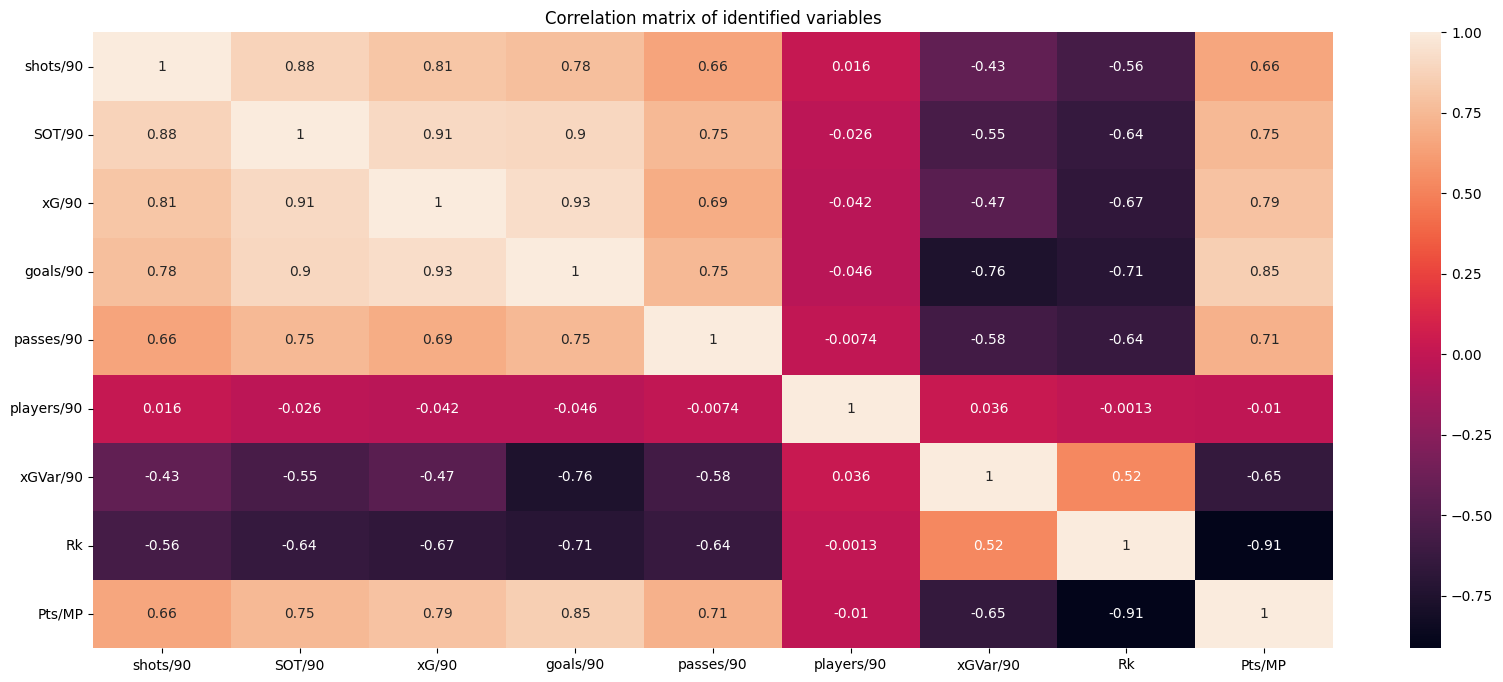

In [13]:
numeric_data = merged_df.drop(columns=(['team','Squad', 'League','shots',
        'shotsOnTarget',
        'xG',
        'goals',
        'passes',
        'players'
        , 'own_goals'
        , 'match_count'])) #remove columns containing strings or are not per match counts to enable the correlation matrix

plt.figure(figsize=(20,8))

dataplot = sns.heatmap(numeric_data.corr(), annot=True)
plt.title("Correlation matrix of identified variables")
plt.show()

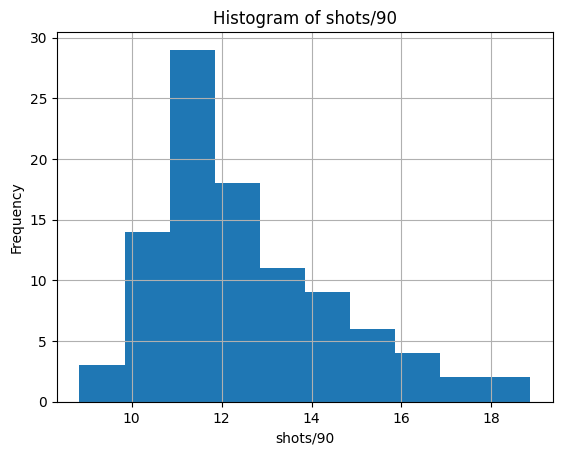

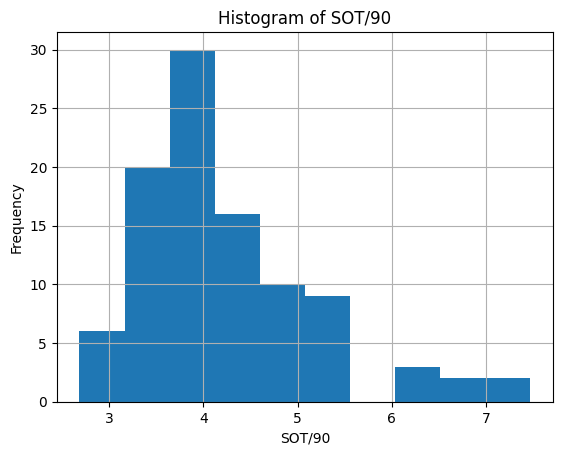

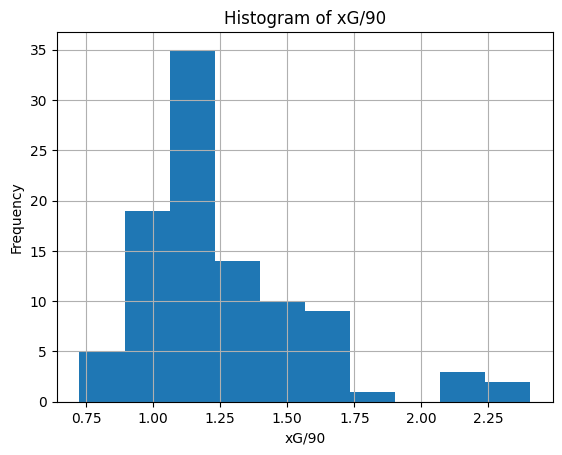

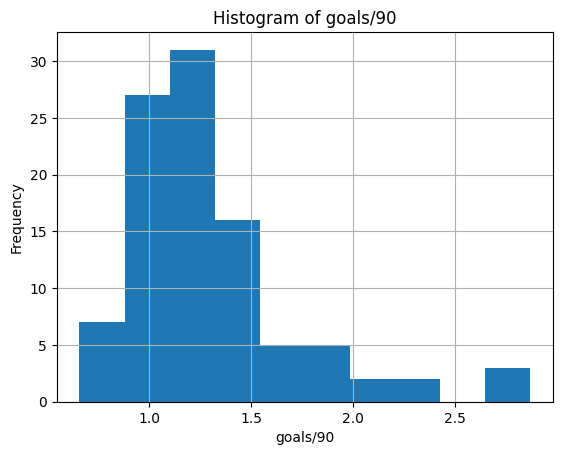

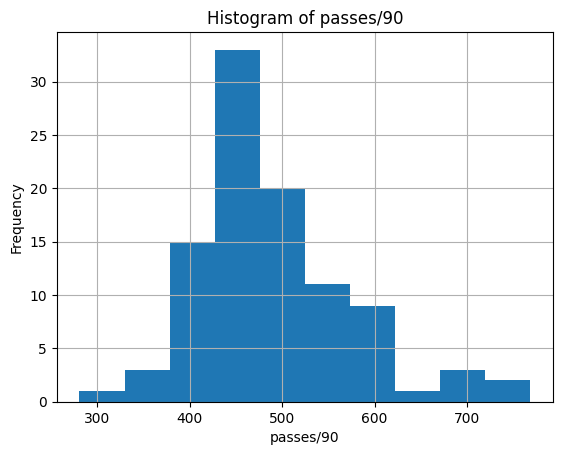

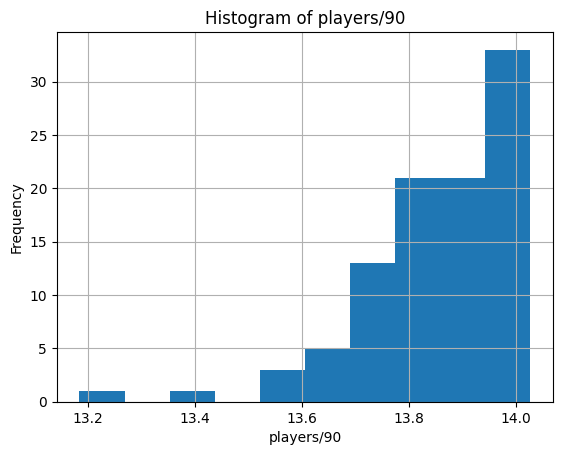

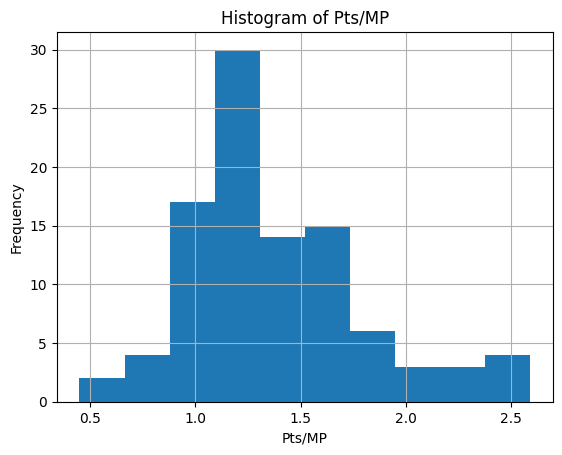

In [14]:
columns = ['shots/90', 'SOT/90', 'xG/90', 'goals/90', 'passes/90','players/90','Pts/MP']

for col in columns:
    plt.figure()
    numeric_data[col].hist(bins=10)  # you can adjust the bins as needed
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

The distribution for a number of variables clearly do not represent a normal distibution and should be considered when applying statistical models before proper processing of data, given the presence of skewness or kurtosis in a distribution can hinder the ability of models to operate effectively.

I then considered the potential for multicollinearity in the dataset by calculating the variance inflation factor of each variable.

In [15]:
vif_features = numeric_data.drop(columns=(['Rk']))

def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif["features"] = dataset.columns
    vif["VIF_Value"] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    return(vif)

features = vif_features
vif_values = calculate_vif(features)
vif_values

C:\Program Files\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF_Value
0,shots/90,186.328390
1,SOT/90,225.397250
2,xG/90,inf
3,goals/90,inf
4,passes/90,95.127845
5,players/90,73.640495
6,xGVar/90,inf
7,Pts/MP,44.844137


Given that a VIF value of less than 10 suggests a model is unlikely to be impacted by multi-collinearity, we should be incredibly cautious of the resulting values and investigate opportunities to reduce the variance inflation factor wherever possible.

#### SHAP Values

By calculating the SHAP values for each feature, we can begin to understand how each input variable/feature contributes towards the predictions made by a machine learning model. By doing this, we should be able to remove factors which are providing little value and could be adding unwanted noise to the solution.

For the purpose of this model, I implemented a Random Forest Regressor to calculate the values from.

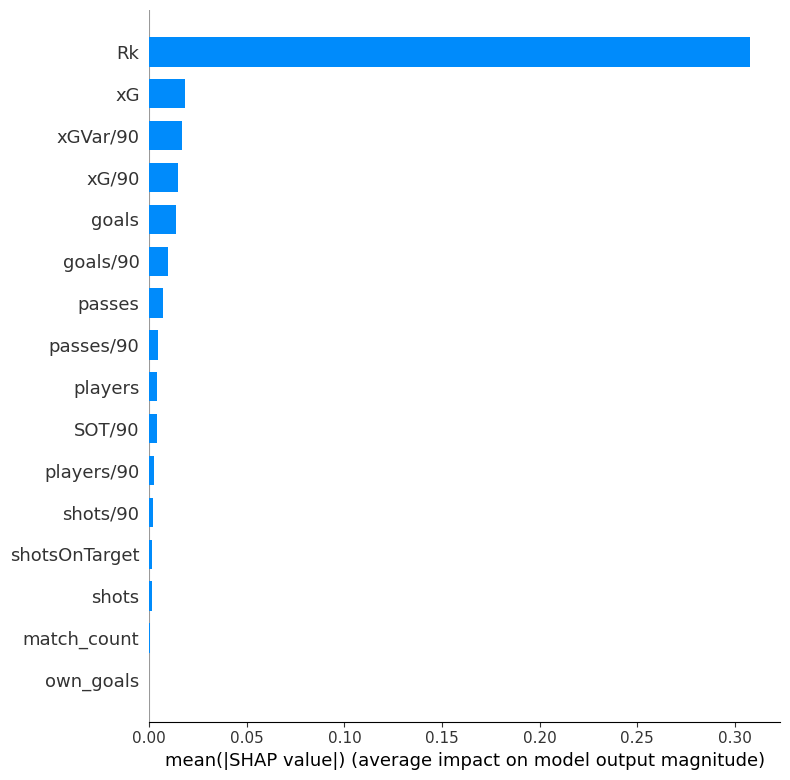

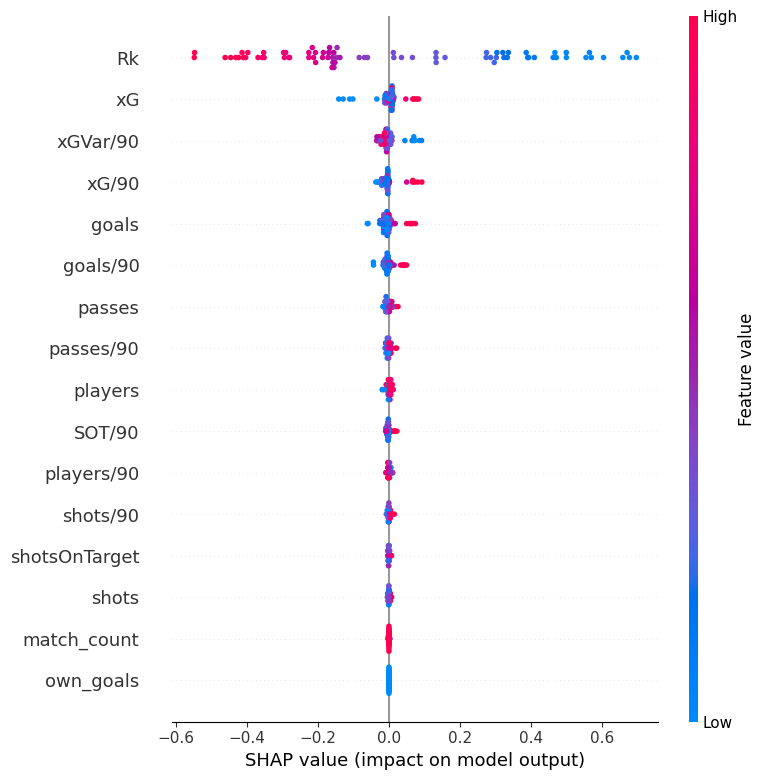

In [16]:
shap_df = merged_df._get_numeric_data()

# Define the target variable and features
y = shap_df['Pts/MP']
X = shap_df.drop(['Pts/MP'], axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# Visualize the overall feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Visualize the importance of features for each prediction
shap.summary_plot(shap_values, X_train)

'Rank' has significant feature importance and influence on the predictability of the regressor model. Given the target variable is points by matches played, this is unhelpful as there is a clear negative correlation between 'Pts/MP' and 'Rank', supported by the correlation matrix.

For this reason, I will remove the 'Rank' column and run the SHAP values again.

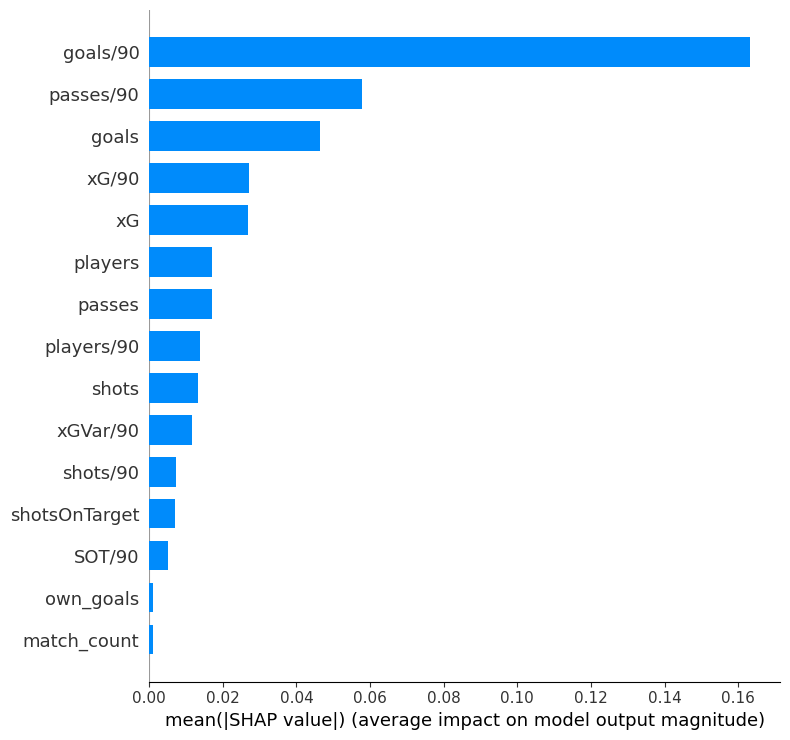

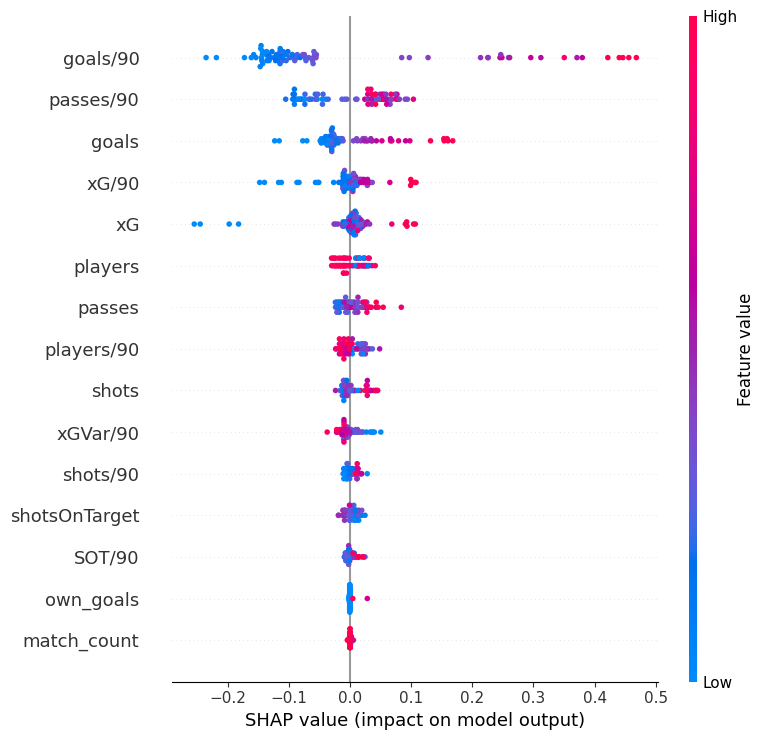

In [17]:
#removing 'Pts/MP' recognising the influence it had on SHAP values


features_to_drop = ['Rk']


#features_to_drop = ['Rk', 'Unnamed: 0', 'match_count']

shap_df = merged_df._get_numeric_data()
shap_df = shap_df.drop(columns=(features_to_drop))

# Assume `df` is your DataFrame and has already been defined
# Define the target variable and features
y = shap_df['Pts/MP']
X = shap_df.drop(['Pts/MP'], axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# Visualize the overall feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Visualize the importance of features for each prediction
shap.summary_plot(shap_values, X_train)

The bar plot above shows us the rate to which each variable is expected to contribute towards model predictions, with 'goals/90' having the highest positive contribution.

The beeswarm plot above shows us the impact that each variable has on model performance, for example we can see that higher values of 'goals/90' are associated with more positive values of 'Pts/MP'. 

Presenting a dependence plot shows us rich information about the nature of relationship between a feature and the predicted outcomes. We can examine the treshold at which a feature is expected to contribute to a higher value of 'Pts/MP', each features beeswarm plot has been plotted below.

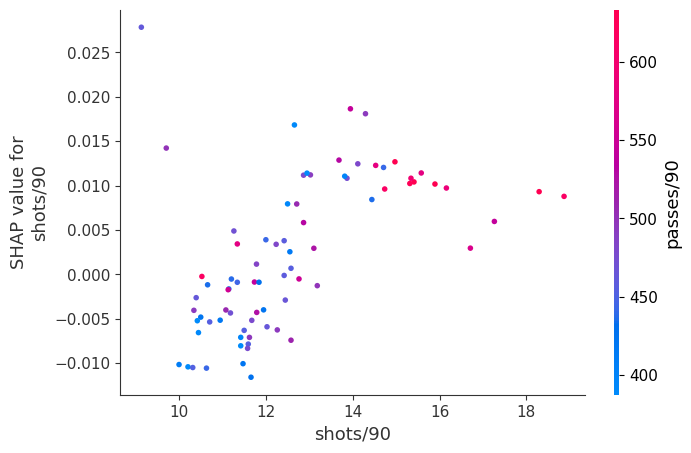

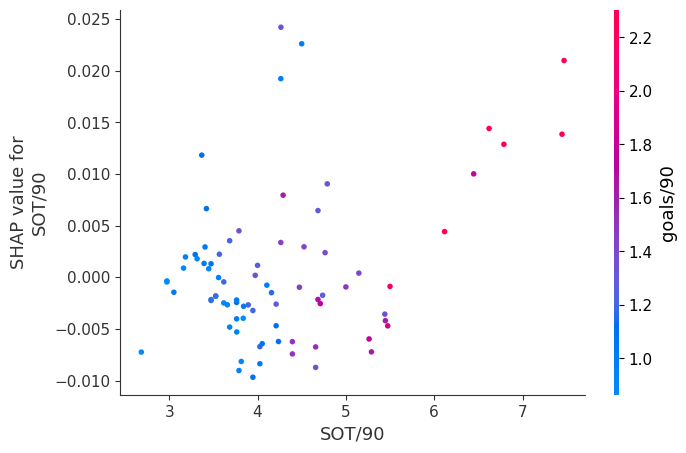

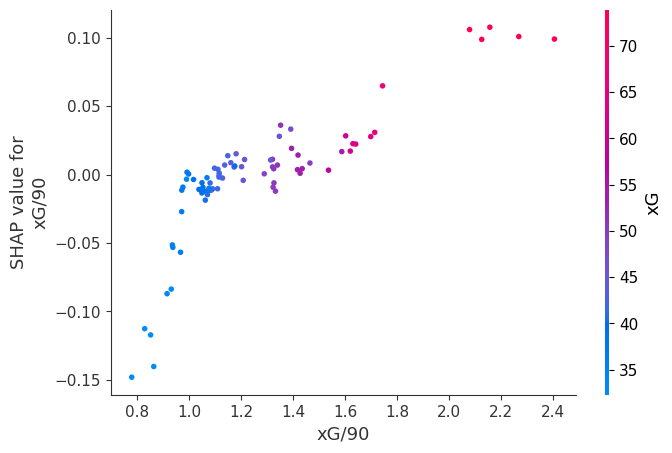

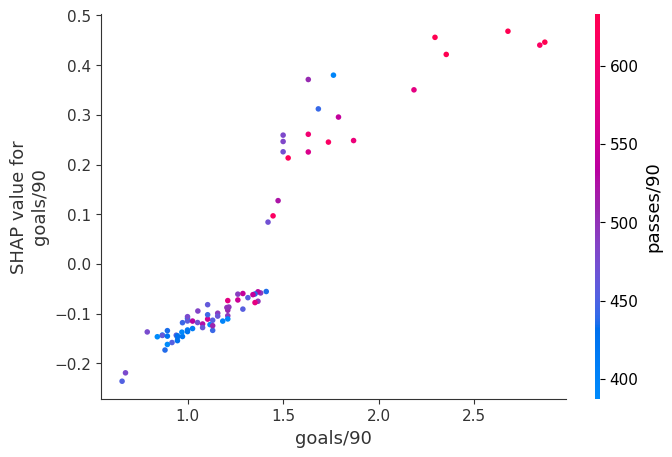

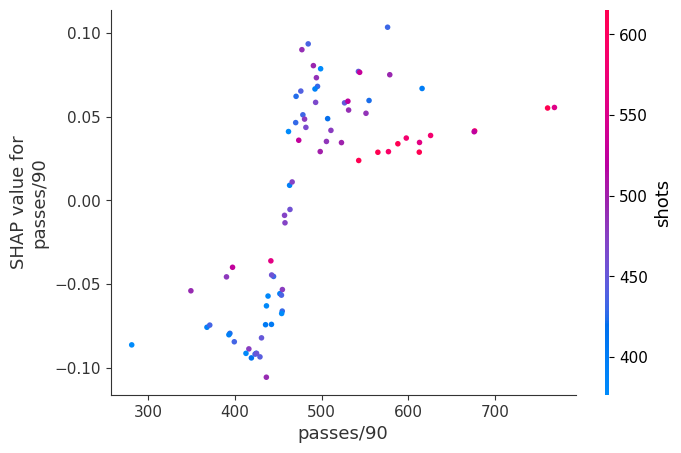

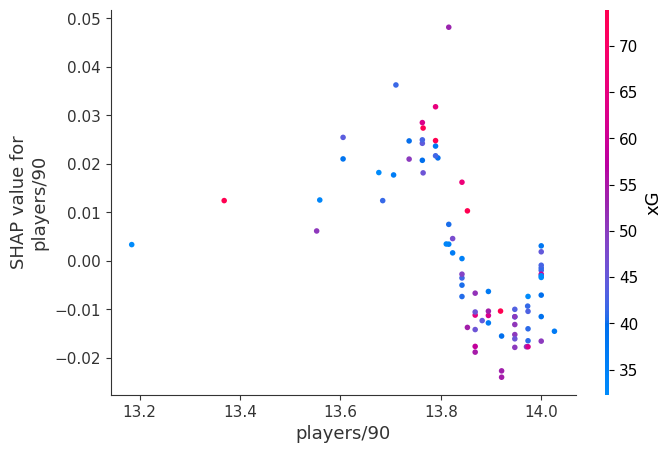

In [18]:
columns = ['shots/90', 'SOT/90', 'xG/90', 'goals/90', 'passes/90','players/90']


# Compute SHAP values for the test set
shap_values_train = explainer(X_train).values

# Example of dependence plot for a specific feature

for col in columns:
    shap.dependence_plot(col, shap_values_train, X_train)

We can see a strong, positive linear relationship between some features and the respective SHAP values, like in 'goals/90'. For others (like 'xG/90'), there is a vertical spread that shows that other features have an influence on the output here, as is seen when the xG/90 is equal to approximately 1. Further analysis of the 'goals/90' dependence plot reveals that teams who made more passes were also more likely to achieve more goals.

### Clustering

In [19]:
features_to_drop = ['match_count', 'shots',
        'shotsOnTarget',
        'xG',
        'goals',
        'passes',
        'players']

k_means = shap_df._get_numeric_data()
k_means = k_means.drop(columns=(features_to_drop))
k_means.describe().round(2)

,own_goals,shots/90,SOT/90,xG/90,goals/90,passes/90,players/90,xGVar/90,Pts/MP
count,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00
mean,0.05,12.54,4.24,1.26,1.29,487.46,13.85,-0.03,1.37
std,0.33,2.00,0.95,0.32,0.43,83.84,0.14,0.18,0.43
min,0.00,8.84,2.68,0.73,0.66,280.85,13.18,-0.72,0.45
25%,0.00,11.19,3.62,1.06,1.00,436.18,13.79,-0.12,1.11
50%,0.00,11.97,4.01,1.17,1.18,470.25,13.87,-0.03,1.26
75%,0.00,13.62,4.66,1.41,1.44,529.30,13.95,0.06,1.62
max,3.00,18.87,7.47,2.41,2.87,768.54,14.03,0.31,2.59


Given the noticeable difference in standard deviation for passes/90 compared to the other variables, if we do not normalize or standardize the data then other variables will have a negligible contribution towards the clustering.

We will perform z-score normalisation on the data. 

We will also reduce the variables to just those with a high SHAP influence.

In [23]:
#features to include in clustering (x-axis variables)
x_features = ['goals/90', 'passes/90','xG/90','SOT/90']
scaler = StandardScaler()
x_scaled = scaler.fit_transform(k_means[x_features])
y_feature = 'Pts/MP'

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_features = shap_df._get_numeric_data()
vif_features = vif_features[['goals/90','passes/90','xG/90','players/90','SOT/90','Pts/MP']]

def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif["features"] = dataset.columns
    vif["VIF_Value"] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    return(vif)

features = vif_features
vif_values = calculate_vif(features)
vif_values

,features,VIF_Value
0,goals/90,121.184770
1,passes/90,95.127825
2,xG/90,165.800449
3,players/90,51.729797
4,SOT/90,154.433782
5,Pts/MP,44.726554


Investigating the prevalence of collinearity in the report, we can see that we are not returning infinity amounts but are still returning significantly high values. We should only accept values which are less than ten, each of these features exceed that by at least a multiple of four, with some extending to a near 17 multiplier. It is advised that future iterations of this producy implement a dimensionality reduction technique, like PCA to mitigate the influence of collinearity.


#### Choosing the correct number of clusters

In [25]:
km = KMeans(n_clusters = 3, n_init = 25, random_state = 1234) # 1. number of k. 2. number of times the algorithm should be run with different centroid seeds. 3. random centroid seed
k_means['Cluster'] = km.fit_predict(x_scaled)

#cluster centroids
centroids = scaler.inverse_transform(km.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=x_features)
centroid_df['Cluster']=range(3)

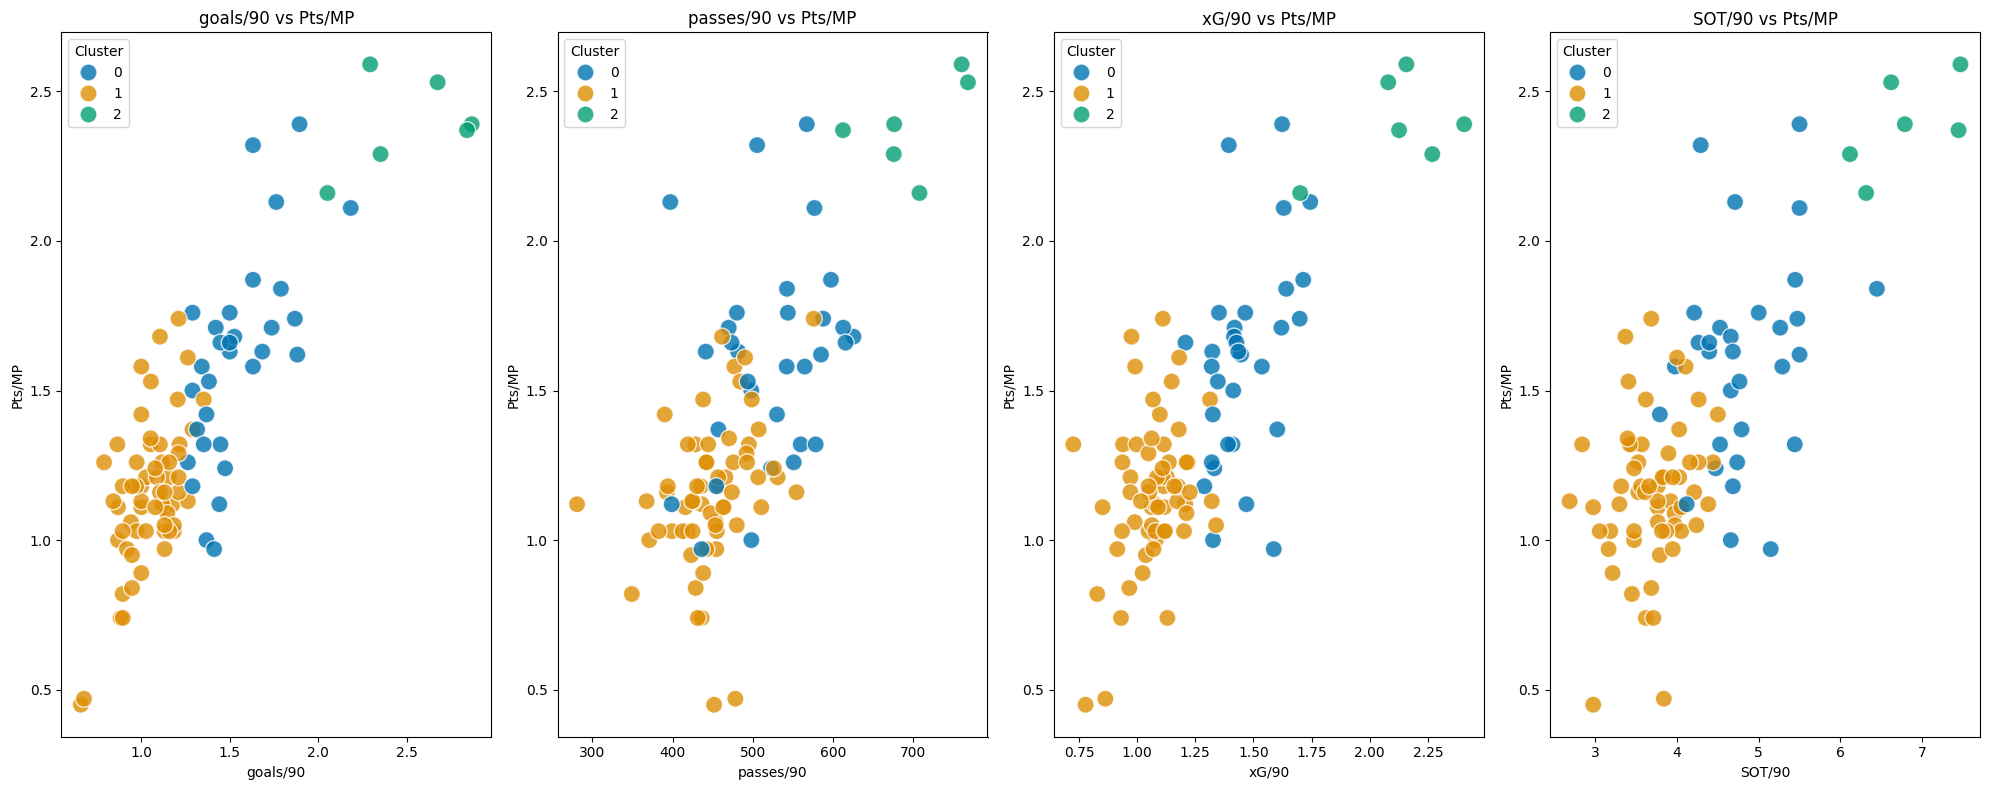

In [26]:
# Set up the subplots for each feature vs the y-axis variable
fig, axes = plt.subplots(1, len(x_features), figsize=(20, 8))

for i, x_feature in enumerate(x_features):
    ax = sns.scatterplot(data=k_means,
                         x=x_feature,
                         y=y_feature, 
                         hue='Cluster', 
                         palette='colorblind', 
                         alpha=0.8, 
                         s=150,
                         legend=True,
                         ax=axes[i])
    axes[i].set_title(f"{x_feature} vs {y_feature}")

plt.tight_layout()
plt.show()


This assumes that three is the optimal number of clusters, we will now evaluate a number of tests to determine if this is correct.

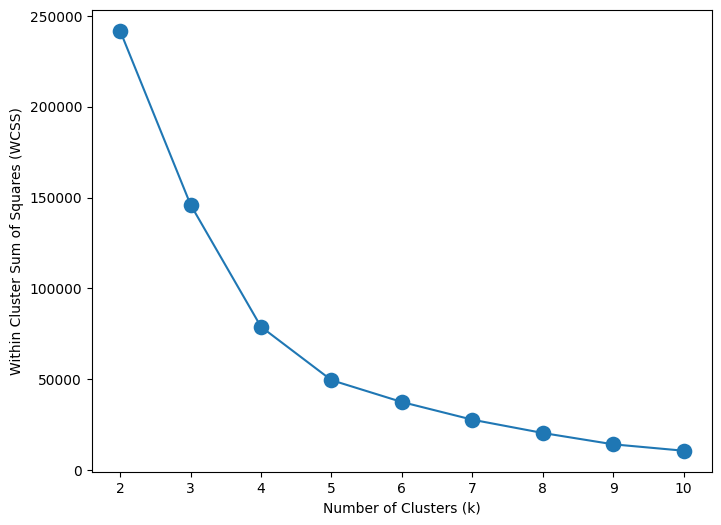

In [27]:
#WCSS

wcss = []
for k in range(2, 11): #k from 2 - 10
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(k_means)
    wcss.append(km.inertia_) #wcss value for each k value stored using inertia_

wcss_series = pd.Series(wcss, index = range(2, 11)) #converting list to pandas

#plotting the k values with corresponding WCSS values

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
ax = sns.scatterplot(y = wcss_series, x = wcss_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Within Cluster Sum of Squares (WCSS)')

In [28]:
wcss_series

2     241777.898080
3     146091.009997
4      78887.790783
5      49511.305760
6      37482.640720
7      27752.758363
8      20448.279350
9      14205.520908
10     10687.482087
dtype: float64

Reviewing where the reduction in WCSS begins to slow down, suggests that we should be stating that k (our number of clusters) is equivalent to 4 or 5.

WCSS - K = 4:5

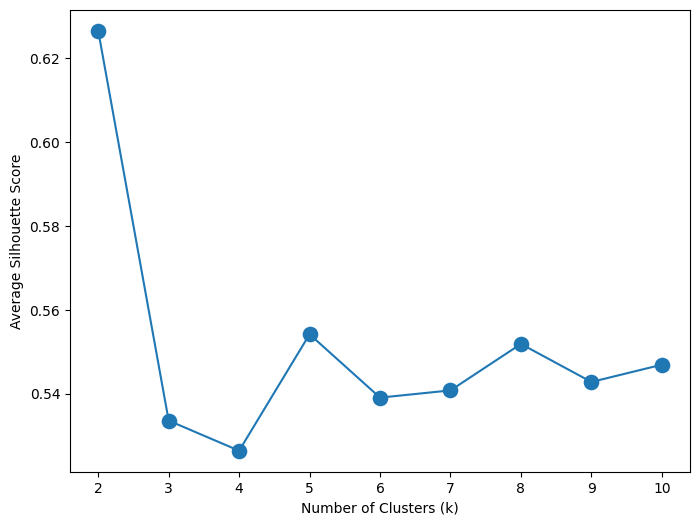

In [32]:
#Average Silhouette Score
silhouette = []
for k in range(2, 11): #k from 2 - 10
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(k_means)
    silhouette.append(silhouette_score(k_means, km.labels_)) # silhoutte value for each k stored

silhouette_series = pd.Series(silhouette, index = range(2, 11)) #converting list to pandas 

#plotting the k values with corresponding silhouette scores

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = silhouette_series, x = silhouette_series.index)
ax = sns.scatterplot(y = silhouette_series, x = silhouette_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Average Silhouette Score')

The highest silhouette score indicates the most optimal number of clusters, according to this method. This states that k should be 2.

Silhouette score - K=2

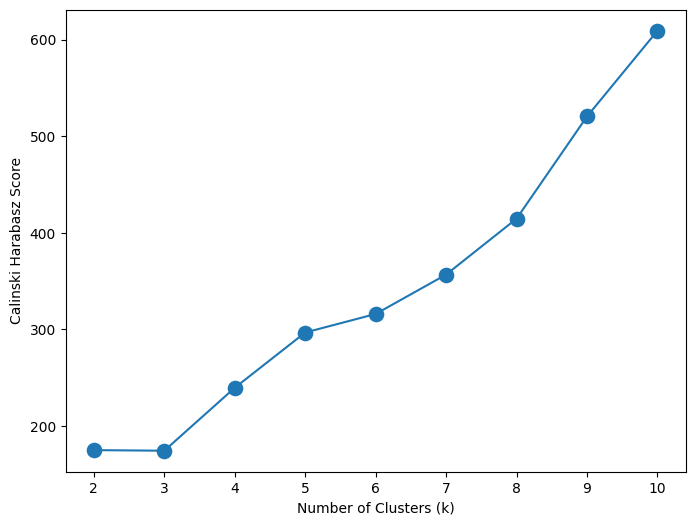

In [33]:
calinski = []
for k in range(2, 11): # from k-10
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(k_means)
    calinski.append(calinski_harabasz_score(k_means, km.labels_)) #c_h score for each k value stored

calinski_series = pd.Series(calinski, index = range(2, 11)) #convert list to pandas

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = calinski_series, x = calinski_series.index)
ax = sns.scatterplot(y = calinski_series, x = calinski_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Calinski Harabasz Score')

The Calinski-Harabasz score suggests that continually improving k is optimal. 

Given the outputs from all three tests, I have elected to begin with k = 4, which should allow for a good balance between cluster quality and interpretability. 

It's always important to consider the business domain being analysed, when considering the value of k.

#### Applying K-Means on Identified Cluster Size

In [37]:
km = KMeans(n_clusters = 4, n_init = 25, random_state = 1234) # 1. number of k. 2. number of times the algorithm should be run with different centroid seeds. 3. random centroid seed
k_means['Cluster'] = km.fit_predict(x_scaled)

#cluster centroids
centroids = scaler.inverse_transform(km.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=x_features)
centroid_df['Cluster']=range(4)

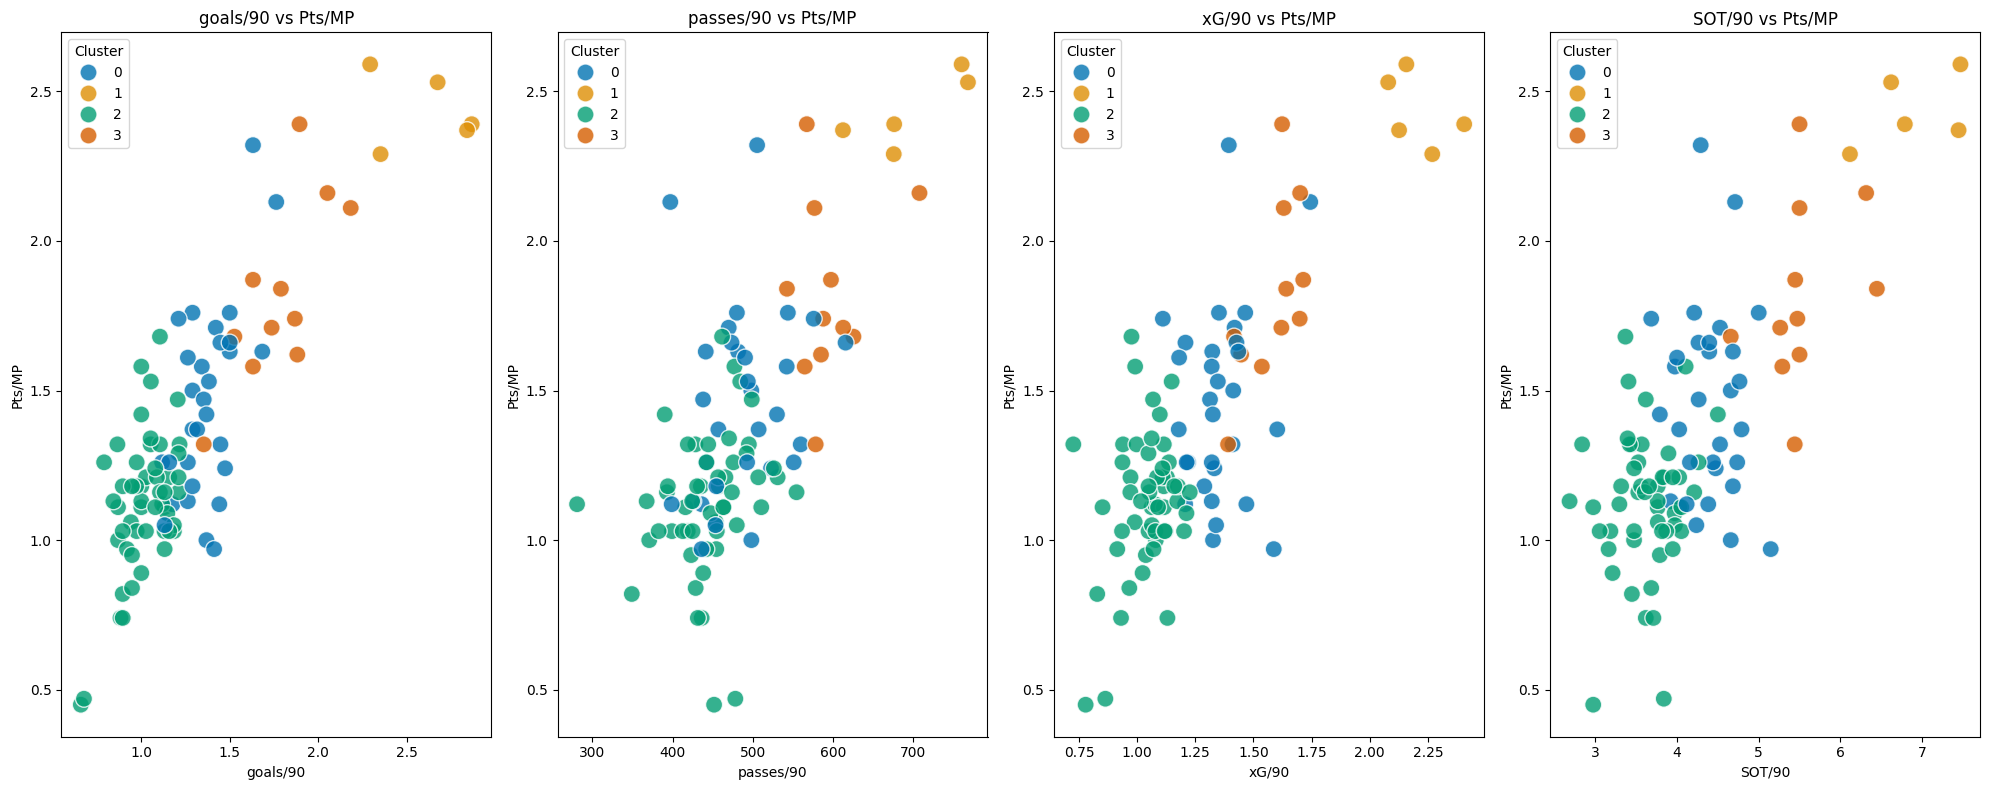

In [38]:
# Set up the subplots for each feature vs the y-axis variable
fig, axes = plt.subplots(1, len(x_features), figsize=(20, 8))

for i, x_feature in enumerate(x_features):
    ax = sns.scatterplot(data=k_means,
                         x=x_feature,
                         y=y_feature, 
                         hue='Cluster', 
                         palette='colorblind', 
                         alpha=0.8, 
                         s=150,
                         legend=True,
                         ax=axes[i])
    """
    # Plot the Centroids
    sns.scatterplot(data=centroid_df, 
                    x=x_feature,
                    y=[k_means[y_feature].mean()] * 3,  # This is just to position the centroids correctly
                    hue='Cluster', 
                    palette='colorblind', 
                    s=600,
                    marker='D',
                    ec='black',
                    legend=False,
                    ax=axes[i])
    """
    axes[i].set_title(f"{x_feature} vs {y_feature}")

plt.tight_layout()
plt.show()


In [36]:
k_means.groupby('Cluster').agg({
    'Pts/MP':'mean', 
    'goals/90':'mean',
    'passes/90':'mean',
    'xG/90':'mean',
    'players/90':'mean',
    'SOT/90':'mean'}).round(2).sort_values('Pts/MP',ascending=False)

,Pts/MP,goals/90,passes/90,xG/90,players/90,SOT/90
Cluster,,,,,,
1,2.43,2.61,698.85,2.21,13.74,6.89
3,1.82,1.78,595.26,1.58,13.89,5.53
0,1.46,1.37,487.19,1.35,13.86,4.40
2,1.12,1.02,444.48,1.04,13.85,3.63


### Conclusion

Returning to the research question, teams who can retain possession of the ball and amass a higher number of passes are more likely to produce more shots on target throughout the game and subsequently generate a higher expected goal (xG) value. 

There is no suggestion that having a 'deeper' squad, and utilising your bench more frequently is correlated to an increased performance on the pitch as the cluster with the highest number of players used per 90 produce the 3rd best, out of 4, points per match. 

The recommendation to clubs is to review their season results and determine which cluster their performance is likely to result in. Recommended steps to improve their ability to increase the number of passes include a review of:
1. How does your team handle the ball from a goal-kick? Could you play the ball short, as opposed to aiming for a target player and looking for a knock-down?
2. How often does your team produce a 'turn-over' that results in a loss of possession? Are these avoidable?
3. Is your defensive shape enabling teams to pass the ball past you? Review pressing opportunities to understand if you can prevent teams from establishing a control over the game which could result in an increased number of shots on target and subsequently improve the number of points they are expected to get from the match.